# When stuff is not missing at random
In the discussion https://www.kaggle.com/c/tabular-playground-series-sep-2021/discussion/270206, Ryan Holbrook from Kaggle staff, remarked that missingness is the magic feature because they intentionally correlated missingness with the claim target. That's why summing the number of missing features per case is such a predictive feature :-)

Anyway, is it just the number of missing features per case or we can extract further information from missin cases, such as specific patterns?

In this notebook, t-SNE and UMAP are used to try to extract further features from missing cases. In particular t-SNE seems able to extract an almost complete separation between claims and it could be useful as a predictive feature.

T-SNE (https://lvdmaaten.github.io/tsne/) and UMAP (https://github.com/lmcinnes/umap) are two technicalities, often used by data scientists, that allow to project multivariate data into lower dimensions. They are often used to find clusters in data. I used the fast t-SNE and UMAP implementations offered by Rapids (they require GPU access). 

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import os
import pprint
import joblib
from time import time
from functools import partial

# Data processing libraries
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Machine learning libraries
import lightgbm as lgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

# GPU-accelerated libraries
import cudf, cuml
import cupy as cp
from cuml.manifold import TSNE, UMAP

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim, xlim

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading data 
X_train = pd.read_csv("../input/tabular-playground-series-sep-2021/train.csv")
X_test = pd.read_csv("../input/tabular-playground-series-sep-2021/test.csv")

In [3]:
# Preparing data as a tabular matrix
y = X_train.claim
X_train = X_train.set_index('id').drop('claim', axis='columns')
X_test = X_test.set_index('id')

In [4]:
# Elaborating missing indicators
X = pd.concat([X_train.isna().astype(int), 
               X_test.isna().astype(int)], ignore_index=True)

In [5]:
tsne = TSNE(n_components=2, perplexity=10, n_neighbors=100)
projection_2D = tsne.fit_transform(X)

In [6]:
projection_2D_train = projection_2D[:len(X_train), :]
projection_2D_test = projection_2D[len(X_train):, :]

In [7]:
valid_0 = (projection_2D_train[:,0] < 300) & (projection_2D_train[:,0] >-300)
valid_1 = (projection_2D_train[:,1] < 300) & (projection_2D_train[:,1] >-300)
valid = valid_0 & valid_1

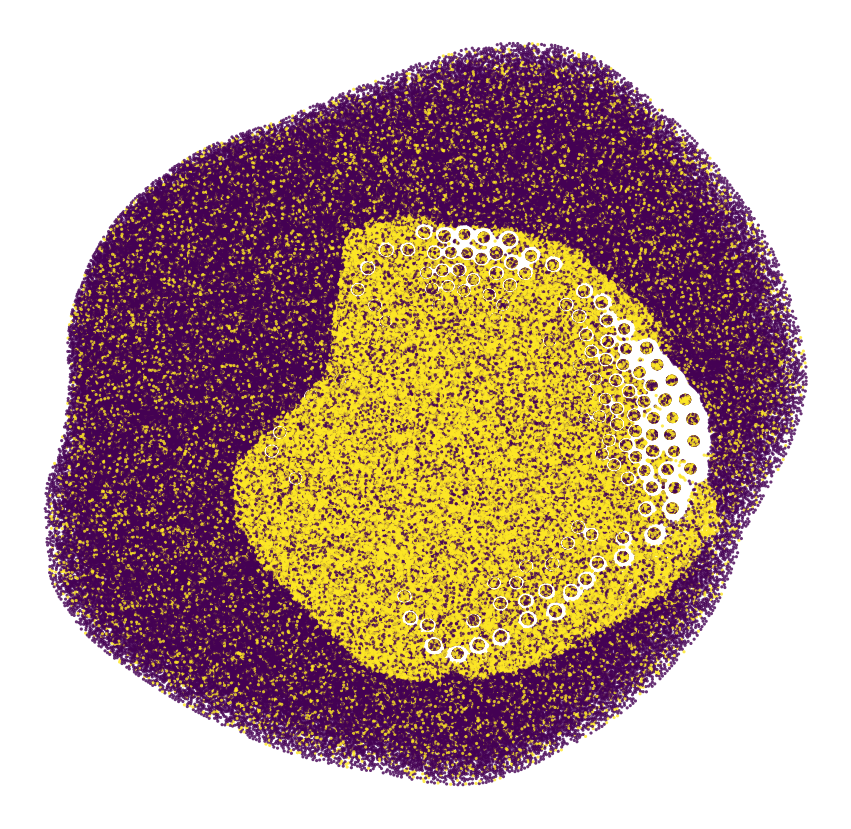

In [8]:
plt.figure(figsize=(15, 15))
plt.scatter(projection_2D_train[valid, 0], projection_2D_train[valid, 1],
            c=y.values[valid],
            edgecolor='none', 
            alpha=0.80, 
            s=10)
plt.axis('off')
plt.show();

Bingo! The positive claims are segregated into a specific area, meaning they are predictable based on the missing patterns.

In [9]:
X_train['t_sne_0'] = projection_2D_train[:, 0]
X_test['t_sne_0'] = projection_2D_test[:, 0]

X_train['t_sne_1'] = projection_2D_train[:, 1]
X_test['t_sne_1'] = projection_2D_test[:, 1]

In [10]:
# UMAP
umap = UMAP(n_components=2, n_neighbors=70)
projection_2D = umap.fit_transform(X)

In [11]:
projection_2D_train = projection_2D[:len(X_train), :]
projection_2D_test = projection_2D[len(X_train):, :]

In [12]:
valid_0 = (projection_2D_train[:,0] < 2000) & (projection_2D_train[:,0] >-2000)
valid_1 = (projection_2D_train[:,1] < 2000) & (projection_2D_train[:,1] >-2000)
valid = valid_0 & valid_1

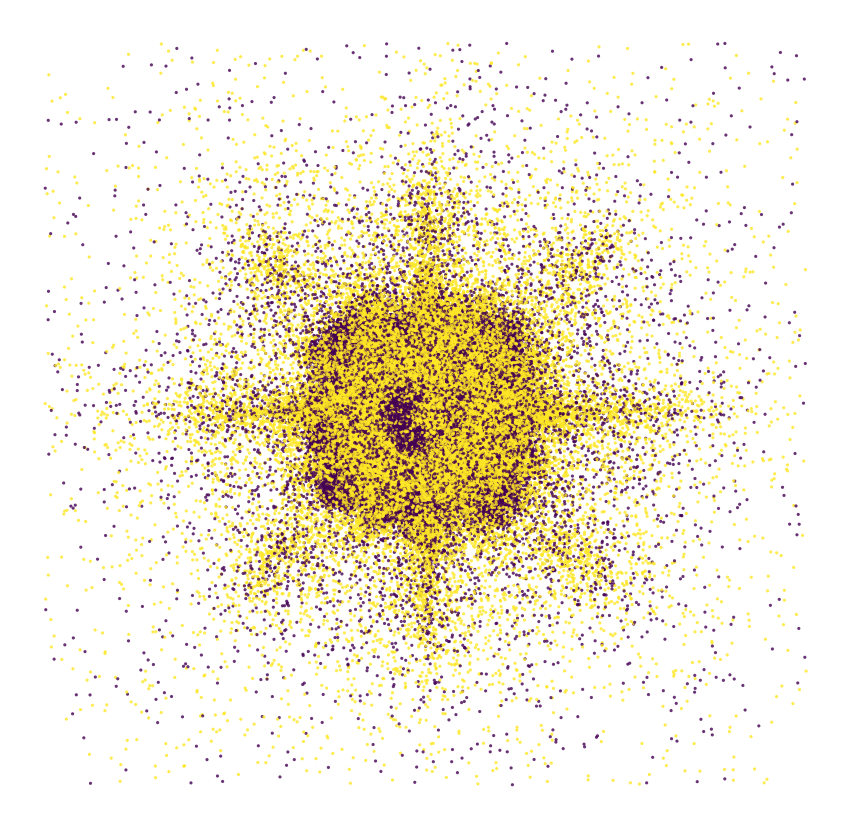

In [13]:
plt.figure(figsize=(15, 15))
plt.scatter(projection_2D_train[valid, 0], projection_2D_train[valid, 1],
            c=y.values[valid],
            edgecolor='none', 
            alpha=0.80, 
            s=10)
plt.axis('off')
plt.show();

Uhmmm...this start shaped result is quite uncommon, I wonder if it can be useful...anyway this is the first time I see this shape!

In [14]:
X_train['t_umap_0'] = projection_2D_train[:, 0]
X_test['t_umap_0'] = projection_2D_test[:, 0]

X_train['t_umap_1'] = projection_2D_train[:, 1]
X_test['t_umap_1'] = projection_2D_test[:, 1]

You can use the coordinates elaborated by t-SNE and UMAP as features. By making them interact you could even use them for linear models and neural networks, making them even more effective.

In [15]:
# Saving the t-SNE and UMAP coordinates as feature
X_train['claim'] = y
X_train.reset_index().to_csv("train.csv", index=False)
X_test.reset_index().to_csv("test.csv", index=False)